In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

!pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import numpy as np
from scipy.stats import shapiro, normaltest, probplot

from statsmodels.tsa.seasonal import seasonal_decompose

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
%run "/variables.py"
%run "/functions.ipynb"

In [9]:
# df = pd.read_csv(f'{DATA_DIR}/pred_maint_timeseries_with_failures.csv')
df = pd.read_csv(f'{DATA_DIR}/pred_maint_year_outliers_nulls.csv')
display(df.head())

,machineid,datetimestamp,enginegastemperature1,enginegastemperature2,enginegastemperature3,enginegastemperature4,enginegastemperature5,enginegastemperature6,pressure
0,1,2025-01-01 00:00:00,302.483571,385.408617,303.238443,307.615149,298.829233,298.829315,103.158426
1,1,2025-01-01 00:10:00,303.837174,300.111109,297.861035,297.340913,299.412622,301.110395,98.464047
2,1,2025-01-01 00:20:00,299.877724,301.777757,302.085056,304.162309,298.533004,299.850807,100.190252
3,1,2025-01-01 00:30:00,303.323272,303.895963,294.494511,305.651141,301.865595,298.067635,97.682460
4,1,2025-01-01 00:40:00,297.766293,NaN,301.614999,NaN,289.108329,294.780518,100.345387


In [10]:

df.drop(columns=['machineid'])
df = df.set_index('datetimestamp')
display(df.head())

,machineid,enginegastemperature1,enginegastemperature2,enginegastemperature3,enginegastemperature4,enginegastemperature5,enginegastemperature6,pressure
datetimestamp,,,,,,,,
2025-01-01 00:00:00,1,302.483571,385.408617,303.238443,307.615149,298.829233,298.829315,103.158426
2025-01-01 00:10:00,1,303.837174,300.111109,297.861035,297.340913,299.412622,301.110395,98.464047
2025-01-01 00:20:00,1,299.877724,301.777757,302.085056,304.162309,298.533004,299.850807,100.190252
2025-01-01 00:30:00,1,303.323272,303.895963,294.494511,305.651141,301.865595,298.067635,97.682460
2025-01-01 00:40:00,1,297.766293,NaN,301.614999,NaN,289.108329,294.780518,100.345387


# Features

Create features to perform isolation forest model in time series dataframe df for anomaly detection

In [11]:
from sklearn.ensemble import IsolationForest

# Create features for Isolation Forest model
# Select relevant features for anomaly detection
isolation_features = [
    'max_abs_zscore',
    'mean_temperature', 
    'std_temperature',
    'range_temperature',
    'high_zscore_count_2sigma',
    'high_zscore_count_3sigma'
]

# Add rolling window features if available
rolling_features = []
for col in sensor_cols:
    rolling_cols = [f'{col}_rolling_std', f'{col}_dev_from_rolling_mean']
    for rcol in rolling_cols:
        if rcol in df_with_zscore_features.columns:
            rolling_features.append(rcol)

# Add differential features
diff_features = []
for col in sensor_cols:
    diff_cols = [f'{col}_diff', f'{col}_diff2']
    for dcol in diff_cols:
        if dcol in df_with_zscore_features.columns:
            diff_features.append(dcol)

# Combine all features for Isolation Forest
all_isolation_features = isolation_features + rolling_features + diff_features

# Create feature matrix for Isolation Forest
df_isolation_features = df_with_zscore_features[all_isolation_features].copy()

# Handle missing values by forward fill then backward fill
df_isolation_features = df_isolation_features.fillna(method='ffill').fillna(method='bfill')

print(f"Features selected for Isolation Forest: {len(all_isolation_features)}")
print(f"Feature matrix shape: {df_isolation_features.shape}")
print(f"Missing values after preprocessing: {df_isolation_features.isnull().sum().sum()}")

# Display sample of features
print("\nSample of Isolation Forest features:")
display(df_isolation_features.head(10))

# Show feature statistics
print("\nFeature Statistics:")
display(df_isolation_features.describe())

/tmp/ipykernel_46025/1468570980.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_isolation_features = df_isolation_features.fillna(method='ffill').fillna(method='bfill')


Features selected for Isolation Forest: 34
Feature matrix shape: (262800, 34)
Missing values after preprocessing: 0

Sample of Isolation Forest features:


,max_abs_zscore,mean_temperature,std_temperature,range_temperature,high_zscore_count_2sigma,high_zscore_count_3sigma,enginegastemperature1_rolling_std,enginegastemperature1_dev_from_rolling_mean,enginegastemperature2_rolling_std,enginegastemperature2_dev_from_rolling_mean,...,enginegastemperature3_diff,enginegastemperature3_diff2,enginegastemperature4_diff,enginegastemperature4_diff2,enginegastemperature5_diff,enginegastemperature5_diff2,enginegastemperature6_diff,enginegastemperature6_diff2,pressure_diff,pressure_diff2
datetimestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,8.301410,316.067388,34.126393,86.579384,1,1,3.406188,1.771328,30.011523,-17.676768,...,-5.377407,9.601427,-10.274236,17.095633,0.583389,-1.463008,2.281079,-3.540667,-4.694379,6.420583
2025-01-01 00:10:00,0.766114,299.945541,2.363995,6.496261,0,0,3.406188,1.771328,30.011523,-17.676768,...,-5.377407,9.601427,-10.274236,17.095633,0.583389,-1.463008,2.281079,-3.540667,-4.694379,6.420583
2025-01-01 00:20:00,0.318559,301.047776,2.021632,5.629305,0,0,3.406188,1.771328,30.011523,-17.676768,...,4.224020,9.601427,6.821396,17.095633,-0.879618,-1.463008,-1.259587,-3.540667,1.726205,6.420583
2025-01-01 00:30:00,1.156868,301.216353,4.166674,11.156630,0,0,3.406188,1.771328,30.011523,-17.676768,...,-7.590544,-11.814564,1.488832,-5.332565,3.332590,4.212209,-1.783172,-0.523585,-2.507792,-4.233997
2025-01-01 00:40:00,1.174450,295.817535,5.275639,12.506670,0,0,3.406188,1.771328,30.011523,-17.676768,...,7.120488,14.711032,1.488832,-5.332565,-12.757266,-16.089856,-3.287117,-1.503945,2.662928,5.170720
2025-01-01 00:50:00,1.218307,305.109845,4.736676,11.962620,0,0,3.406188,1.771328,30.011523,-17.676768,...,11.665051,4.544564,1.488832,-5.332565,19.100527,31.857793,7.523564,10.810681,-0.173540,-2.836468
2025-01-01 01:00:00,1.029949,295.405189,4.214635,12.559909,0,0,3.406188,1.771328,30.011523,-17.676768,...,-22.658434,-34.323486,-8.151341,-5.332565,-5.027330,-24.127857,-6.837685,-14.361248,0.780238,0.953779
2025-01-01 01:10:00,0.767805,302.464903,3.304153,7.747045,0,0,3.406188,1.771328,30.011523,-17.676768,...,10.583995,33.242429,5.992885,14.144226,2.642318,7.669648,3.304865,10.142550,-2.491421,-3.271659
2025-01-01 01:20:00,0.940785,301.413205,5.728850,17.054019,0,0,3.406188,1.771328,30.011523,-17.676768,...,1.083815,-9.500180,-7.580411,-13.573297,-4.189617,-6.831935,0.823144,-2.481721,2.474925,4.966346



Feature Statistics:


,max_abs_zscore,mean_temperature,std_temperature,range_temperature,high_zscore_count_2sigma,high_zscore_count_3sigma,enginegastemperature1_rolling_std,enginegastemperature1_dev_from_rolling_mean,enginegastemperature2_rolling_std,enginegastemperature2_dev_from_rolling_mean,...,enginegastemperature3_diff,enginegastemperature3_diff2,enginegastemperature4_diff,enginegastemperature4_diff2,enginegastemperature5_diff,enginegastemperature5_diff2,enginegastemperature6_diff,enginegastemperature6_diff2,pressure_diff,pressure_diff2
count,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,...,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000
mean,1.530288,300.999057,6.776921,17.426743,0.118398,0.078116,7.412510,-0.020251,7.399100,0.057965,...,-0.014674,0.021013,-0.007598,0.003203,-0.023660,-0.005803,0.006335,0.034534,-0.000974,-0.007033
std,1.760065,4.166743,7.536818,18.990931,0.333477,0.268894,6.959067,9.705299,6.945474,9.767567,...,14.241176,24.705762,14.092666,24.386381,14.324402,24.912351,14.130395,24.437317,2.829977,4.901763
min,0.080866,289.162518,0.135996,0.000000,0.000000,0.000000,0.872462,-33.562565,0.799619,-35.008077,...,-117.222212,-229.771956,-117.721528,-227.175925,-122.483183,-228.467529,-116.667042,-222.931806,-12.082983,-22.294524
25%,0.768260,298.709356,3.677800,9.424382,0.000000,0.000000,4.177699,-4.310440,4.168284,-4.238897,...,-4.923254,-8.432057,-4.918899,-8.415448,-4.912262,-8.375411,-4.926641,-8.437697,-1.910458,-3.299137
50%,1.008049,300.213074,4.801940,12.413379,0.000000,0.000000,5.029511,-0.580156,5.050744,-0.577350,...,-0.010496,0.226178,-0.015052,0.162905,-0.022163,0.171906,0.013510,0.234022,-0.004278,-0.016172
75%,1.376589,301.859074,6.139991,16.033941,0.000000,0.000000,6.129112,2.939525,6.130714,2.960996,...,4.931871,8.967852,4.909261,8.915686,4.890060,8.940783,4.904042,8.918287,1.900295,3.300617
max,11.194764,336.540577,58.176987,123.996513,2.000000,2.000000,44.435581,102.629068,49.051540,101.192480,...,114.755883,195.873383,115.359788,211.451016,119.004465,201.792523,115.108069,186.322846,13.006549,23.928240


# Model

using the features created above, we can now train an isolation forest model to detect anomalies in the time series data. Show the confusion matrix of the anomalies detected by the Z score model and the defined failure flags for temperature sensors. Add evaluation of the model.

Confusion Matrix: Z-score (True) vs Isolation Forest (Predicted)
Rows: Z-score anomalies, Columns: Isolation Forest anomalies
[[1136265   26645]
 [  46335  104755]]


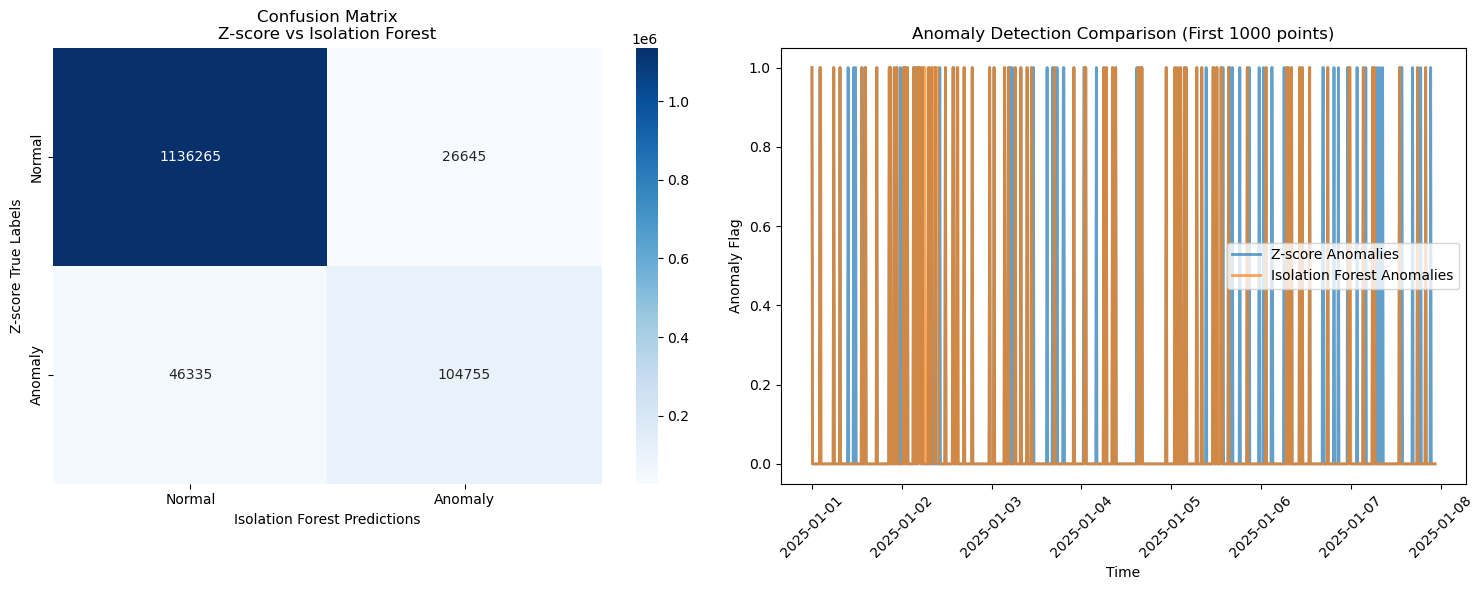


Model Evaluation Metrics:
Accuracy: 0.9445
Precision: 0.7972
Recall: 0.6933
F1-Score: 0.7417

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97   1162910
     Anomaly       0.80      0.69      0.74    151090

    accuracy                           0.94   1314000
   macro avg       0.88      0.84      0.86   1314000
weighted avg       0.94      0.94      0.94   1314000


Anomaly Detection Summary:
Z-score anomalies (2-sigma): 151090/1314000 (11.50%)
Isolation Forest anomalies: 131400/1314000 (10.00%)
Agreement between methods: 94.45%

Anomalous periods identified by Isolation Forest:
Total anomalous periods: 26280
Percentage of data flagged as anomalous: 10.00%

Sample of detected anomalies:


,mean_temperature,std_temperature,max_abs_zscore,anomaly_flag_2sigma,isolation_forest_anomaly,anomaly_score
datetimestamp,,,,,,
2025-01-01 00:00:00,316.067388,34.126393,8.301410,1,1,-0.092003
2025-01-01 02:10:00,314.749370,39.522136,9.105954,1,1,-0.107505
2025-01-01 02:20:00,296.345174,3.771139,0.923289,0,1,-0.027862
2025-01-01 05:50:00,317.934776,40.539492,8.840539,1,1,-0.089518
2025-01-01 07:30:00,316.283175,32.799334,8.194586,1,1,-0.014725
2025-01-01 13:20:00,321.515455,44.101379,9.909312,1,1,-0.058828
2025-01-01 14:20:00,312.225939,38.576830,8.922175,1,1,-0.063050
2025-01-01 17:20:00,313.513031,31.149866,7.336610,1,1,-0.089173
2025-01-01 20:40:00,311.148925,31.109649,7.171822,1,1,-0.105918


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Train Isolation Forest model
iso_forest = IsolationForest(
    contamination=0.1,  # Expect 10% anomalies
    random_state=42,
    n_estimators=100
)

# Fit the model on the feature matrix
iso_forest.fit(df_isolation_features)

# Predict anomalies (-1 for anomaly, 1 for normal)
iso_predictions = iso_forest.predict(df_isolation_features)

# Convert to binary (1 for anomaly, 0 for normal)
iso_anomalies = (iso_predictions == -1).astype(int)

# Add predictions to dataframe
df_with_iso = df_with_zscore_features.copy()
df_with_iso['isolation_forest_anomaly'] = iso_anomalies

# Create confusion matrix comparing Isolation Forest vs Z-score anomalies (2-sigma)

# Get valid indices where both methods have predictions
valid_idx = df_with_iso[['isolation_forest_anomaly', 'anomaly_flag_2sigma']].dropna().index
iso_valid = df_with_iso.loc[valid_idx, 'isolation_forest_anomaly']
zscore_valid = df_with_iso.loc[valid_idx, 'anomaly_flag_2sigma']

# Confusion matrix
cm = confusion_matrix(zscore_valid, iso_valid)

print("Confusion Matrix: Z-score (True) vs Isolation Forest (Predicted)")
print("Rows: Z-score anomalies, Columns: Isolation Forest anomalies")
print(cm)

# Create a more detailed confusion matrix visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
ax1.set_title('Confusion Matrix\nZ-score vs Isolation Forest')
ax1.set_xlabel('Isolation Forest Predictions')
ax1.set_ylabel('Z-score True Labels')

# Plot anomaly comparison over time (sample)
sample_data = df_with_iso.iloc[:1000].copy()
ax2.plot(sample_data.index, sample_data['anomaly_flag_2sigma'], 
         label='Z-score Anomalies', alpha=0.7, linewidth=2)
ax2.plot(sample_data.index, sample_data['isolation_forest_anomaly'], 
         label='Isolation Forest Anomalies', alpha=0.7, linewidth=2)
ax2.set_title('Anomaly Detection Comparison (First 1000 points)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Anomaly Flag')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate evaluation metrics
accuracy = accuracy_score(zscore_valid, iso_valid)
precision = precision_score(zscore_valid, iso_valid)
recall = recall_score(zscore_valid, iso_valid)
f1 = f1_score(zscore_valid, iso_valid)

print(f"\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print(f"\nClassification Report:")
print(classification_report(zscore_valid, iso_valid, target_names=['Normal', 'Anomaly']))

# Summary statistics
print(f"\nAnomaly Detection Summary:")
print(f"Z-score anomalies (2-sigma): {zscore_valid.sum()}/{len(zscore_valid)} ({zscore_valid.mean():.2%})")
print(f"Isolation Forest anomalies: {iso_valid.sum()}/{len(iso_valid)} ({iso_valid.mean():.2%})")

# Agreement analysis
agreement = (zscore_valid == iso_valid).mean()
print(f"Agreement between methods: {agreement:.2%}")

# Show feature importance (anomaly scores)
anomaly_scores = iso_forest.decision_function(df_isolation_features)
df_with_iso['anomaly_score'] = anomaly_scores

print(f"\nAnomalous periods identified by Isolation Forest:")
anomalous_periods = df_with_iso[df_with_iso['isolation_forest_anomaly'] == 1]
print(f"Total anomalous periods: {len(anomalous_periods)}")
print(f"Percentage of data flagged as anomalous: {len(anomalous_periods)/len(df_with_iso):.2%}")

# Display some examples of detected anomalies
print(f"\nSample of detected anomalies:")
display(anomalous_periods[['mean_temperature', 'std_temperature', 'max_abs_zscore', 
                          'anomaly_flag_2sigma', 'isolation_forest_anomaly', 'anomaly_score']].head(10))

TypeError: range indices must be integers or slices, not Series

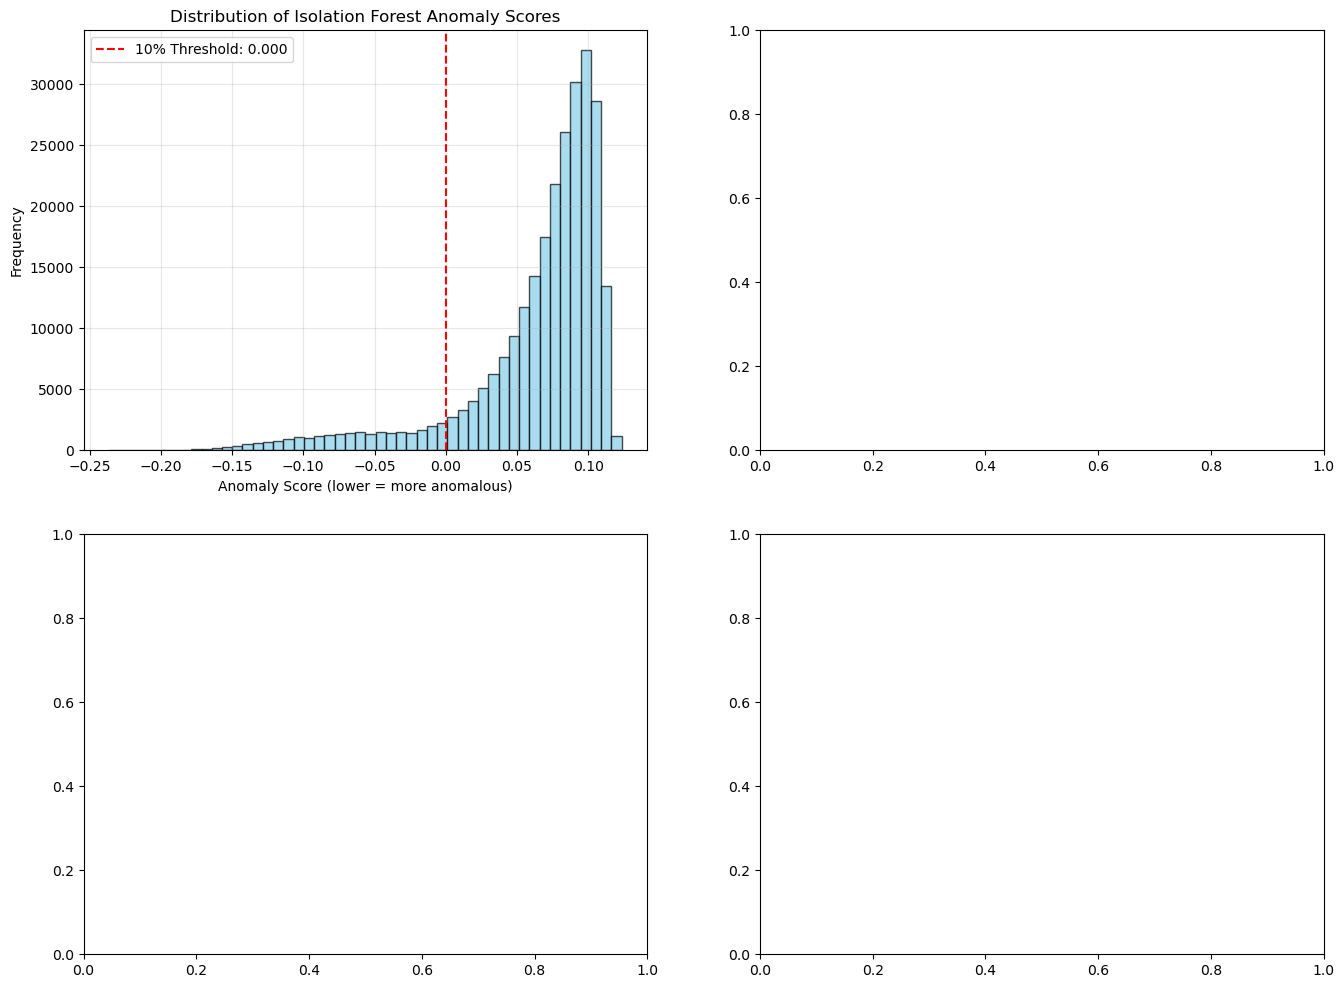

In [13]:
# Create Isolation Forest visualization diagram
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature Importance via Anomaly Scores Distribution
ax1 = axes[0, 0]
ax1.hist(df_with_iso['anomaly_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(df_with_iso['anomaly_score'].quantile(0.1), color='red', linestyle='--', 
            label=f'10% Threshold: {df_with_iso["anomaly_score"].quantile(0.1):.3f}')
ax1.set_title('Distribution of Isolation Forest Anomaly Scores')
ax1.set_xlabel('Anomaly Score (lower = more anomalous)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Time Series View of Anomalies (sample period)
ax2 = axes[0, 1]
sample_period = df_with_iso.iloc[:2000].copy()
time_idx = range(len(sample_period))

# Plot anomaly flags as scatter points
normal_mask = sample_period['isolation_forest_anomaly'] == 0
anomaly_mask = sample_period['isolation_forest_anomaly'] == 1

ax2.scatter(time_idx[normal_mask], sample_period.loc[normal_mask, 'mean_temperature'], 
           c='blue', alpha=0.6, s=10, label='Normal Points')
ax2.scatter(time_idx[anomaly_mask], sample_period.loc[anomaly_mask, 'mean_temperature'], 
           c='red', alpha=0.8, s=30, label='Anomalies')
ax2.set_title('Isolation Forest Anomaly Detection\n(First 2000 points)')
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Mean Temperature')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Feature Space Visualization (2D projection)
ax3 = axes[1, 0]
# Use two most important features for visualization
feature1 = 'max_abs_zscore'
feature2 = 'std_temperature'

sample_viz = df_with_iso.sample(n=5000, random_state=42)  # Sample for performance
normal_viz = sample_viz[sample_viz['isolation_forest_anomaly'] == 0]
anomaly_viz = sample_viz[sample_viz['isolation_forest_anomaly'] == 1]

ax3.scatter(normal_viz[feature1], normal_viz[feature2], 
           c='blue', alpha=0.6, s=20, label='Normal')
ax3.scatter(anomaly_viz[feature1], anomaly_viz[feature2], 
           c='red', alpha=0.8, s=40, label='Anomalies')
ax3.set_title(f'Feature Space: {feature1} vs {feature2}')
ax3.set_xlabel(feature1.replace('_', ' ').title())
ax3.set_ylabel(feature2.replace('_', ' ').title())
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Model Performance Metrics Visualization
ax4 = axes[1, 1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

bars = ax4.bar(metrics, values, color=colors, edgecolor='black', alpha=0.8)
ax4.set_title('Isolation Forest Performance Metrics')
ax4.set_ylabel('Score')
ax4.set_ylim(0, 1)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('Isolation Forest Anomaly Detection Analysis', fontsize=16, y=1.02)
plt.show()

# Print summary statistics
print("="*60)
print("ISOLATION FOREST MODEL SUMMARY")
print("="*60)
print(f"Model Parameters:")
print(f"  - Contamination: 10%")
print(f"  - Number of estimators: 100")
print(f"  - Random state: 42")
print(f"\nDataset:")
print(f"  - Total samples: {len(df_with_iso):,}")
print(f"  - Features used: {len(all_isolation_features)}")
print(f"  - Anomalies detected: {iso_anomalies.sum():,} ({iso_anomalies.mean():.2%})")
print(f"\nPerformance vs Z-score method:")
print(f"  - Agreement: {agreement:.2%}")
print(f"  - Accuracy: {accuracy:.3f}")
print(f"  - Precision: {precision:.3f}")
print(f"  - Recall: {recall:.3f}")
print(f"  - F1-Score: {f1:.3f}")